In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv


In [2]:
!pip install pycaret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 9.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 58.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 79.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 1

## Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import setup, compare_models, blend_models, finalize_model, predict_model, plot_model,tune_model
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
train_data = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2021/train.csv")
test_data = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2021/test.csv")
#concentinating all data to feature engineer both

all_data = pd.concat([train_data,test_data],axis=0)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9358 entries, 0 to 2246
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_time               9358 non-null   object 
 1   deg_C                   9358 non-null   float64
 2   relative_humidity       9358 non-null   float64
 3   absolute_humidity       9358 non-null   float64
 4   sensor_1                9358 non-null   float64
 5   sensor_2                9358 non-null   float64
 6   sensor_3                9358 non-null   float64
 7   sensor_4                9358 non-null   float64
 8   sensor_5                9358 non-null   float64
 9   target_carbon_monoxide  7111 non-null   float64
 10  target_benzene          7111 non-null   float64
 11  target_nitrogen_oxides  7111 non-null   float64
dtypes: float64(11), object(1)
memory usage: 950.4+ KB


#### All columns are numerical so it is better to use regression on this data

In [5]:
# adding date features
all_data["date_time"] = pd.to_datetime(all_data["date_time"])
all_data["year"] = all_data["date_time"].dt.year
all_data["month"] = all_data["date_time"].dt.month
all_data["day"] = all_data["date_time"].dt.day
all_data["day_of_week"] = all_data["date_time"].dt.dayofweek

all_data["time"] = all_data["date_time"].dt.date -all_data["date_time"].dt.date.min()
all_data["hour"] = all_data["date_time"].dt.hour
all_data['time'] = all_data['time'].apply(lambda x : x.days)

all_data.drop(columns = 'date_time', inplace = True)
all_data


,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,year,month,day,day_of_week,time,hour
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7,2010,3,10,2,0,18
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9,2010,3,10,2,0,19
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,2010,3,10,2,0,20
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,2010,3,10,2,0,21
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,2010,3,10,2,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,23.2,28.7,0.7568,1340.3,1023.9,522.8,1374.0,1659.8,NaN,NaN,NaN,2011,4,4,0,390,10
2243,24.5,22.5,0.7119,1232.8,955.1,616.1,1226.1,1269.0,NaN,NaN,NaN,2011,4,4,0,390,11
2244,26.6,19.0,0.6406,1187.7,1052.4,572.8,1253.4,1081.1,NaN,NaN,NaN,2011,4,4,0,390,12
2245,29.1,12.7,0.5139,1053.2,1009.0,702.0,1009.8,808.5,NaN,NaN,NaN,2011,4,4,0,390,13


In [6]:
all_data.info() #we can one hot encode day_of_week column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9358 entries, 0 to 2246
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   deg_C                   9358 non-null   float64
 1   relative_humidity       9358 non-null   float64
 2   absolute_humidity       9358 non-null   float64
 3   sensor_1                9358 non-null   float64
 4   sensor_2                9358 non-null   float64
 5   sensor_3                9358 non-null   float64
 6   sensor_4                9358 non-null   float64
 7   sensor_5                9358 non-null   float64
 8   target_carbon_monoxide  7111 non-null   float64
 9   target_benzene          7111 non-null   float64
 10  target_nitrogen_oxides  7111 non-null   float64
 11  year                    9358 non-null   int64  
 12  month                   9358 non-null   int64  
 13  day                     9358 non-null   int64  
 14  day_of_week             9358 non-null   

In [7]:
#to do that we need to change type to object
all_data["day_of_week"] = all_data["day_of_week"].astype("object")
all_data = pd.get_dummies(all_data)
all_data

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,...,day,time,hour,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,...,10,0,18,0,0,1,0,0,0,0
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,...,10,0,19,0,0,1,0,0,0,0
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,...,10,0,20,0,0,1,0,0,0,0
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,...,10,0,21,0,0,1,0,0,0,0
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,...,10,0,22,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,23.2,28.7,0.7568,1340.3,1023.9,522.8,1374.0,1659.8,NaN,NaN,...,4,390,10,1,0,0,0,0,0,0
2243,24.5,22.5,0.7119,1232.8,955.1,616.1,1226.1,1269.0,NaN,NaN,...,4,390,11,1,0,0,0,0,0,0
2244,26.6,19.0,0.6406,1187.7,1052.4,572.8,1253.4,1081.1,NaN,NaN,...,4,390,12,1,0,0,0,0,0,0
2245,29.1,12.7,0.5139,1053.2,1009.0,702.0,1009.8,808.5,NaN,NaN,...,4,390,13,1,0,0,0,0,0,0


In [8]:
train_featured = all_data[:len(train_data)].copy() #retrieving featured train and test datas
test_featured = all_data[len(train_data):].copy()


In [9]:
train_featured

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,...,day,time,hour,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,...,10,0,18,0,0,1,0,0,0,0
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,...,10,0,19,0,0,1,0,0,0,0
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,...,10,0,20,0,0,1,0,0,0,0
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,...,10,0,21,0,0,1,0,0,0,0
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,...,10,0,22,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,1.3,5.1,...,31,296,20,0,0,0,0,1,0,0
7107,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,1.4,5.8,...,31,296,21,0,0,0,0,1,0,0
7108,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,1.6,5.2,...,31,296,22,0,0,0,0,1,0,0
7109,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1.5,4.6,...,31,296,23,0,0,0,0,1,0,0


In [10]:
test_featured

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,...,day,time,hour,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,NaN,NaN,...,1,297,0,0,0,0,0,0,1,0
1,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0,NaN,NaN,...,1,297,1,0,0,0,0,0,1,0
2,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8,NaN,NaN,...,1,297,2,0,0,0,0,0,1,0
3,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0,NaN,NaN,...,1,297,3,0,0,0,0,0,1,0
4,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3,NaN,NaN,...,1,297,4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,23.2,28.7,0.7568,1340.3,1023.9,522.8,1374.0,1659.8,NaN,NaN,...,4,390,10,1,0,0,0,0,0,0
2243,24.5,22.5,0.7119,1232.8,955.1,616.1,1226.1,1269.0,NaN,NaN,...,4,390,11,1,0,0,0,0,0,0
2244,26.6,19.0,0.6406,1187.7,1052.4,572.8,1253.4,1081.1,NaN,NaN,...,4,390,12,1,0,0,0,0,0,0
2245,29.1,12.7,0.5139,1053.2,1009.0,702.0,1009.8,808.5,NaN,NaN,...,4,390,13,1,0,0,0,0,0,0


## Visualizing target values

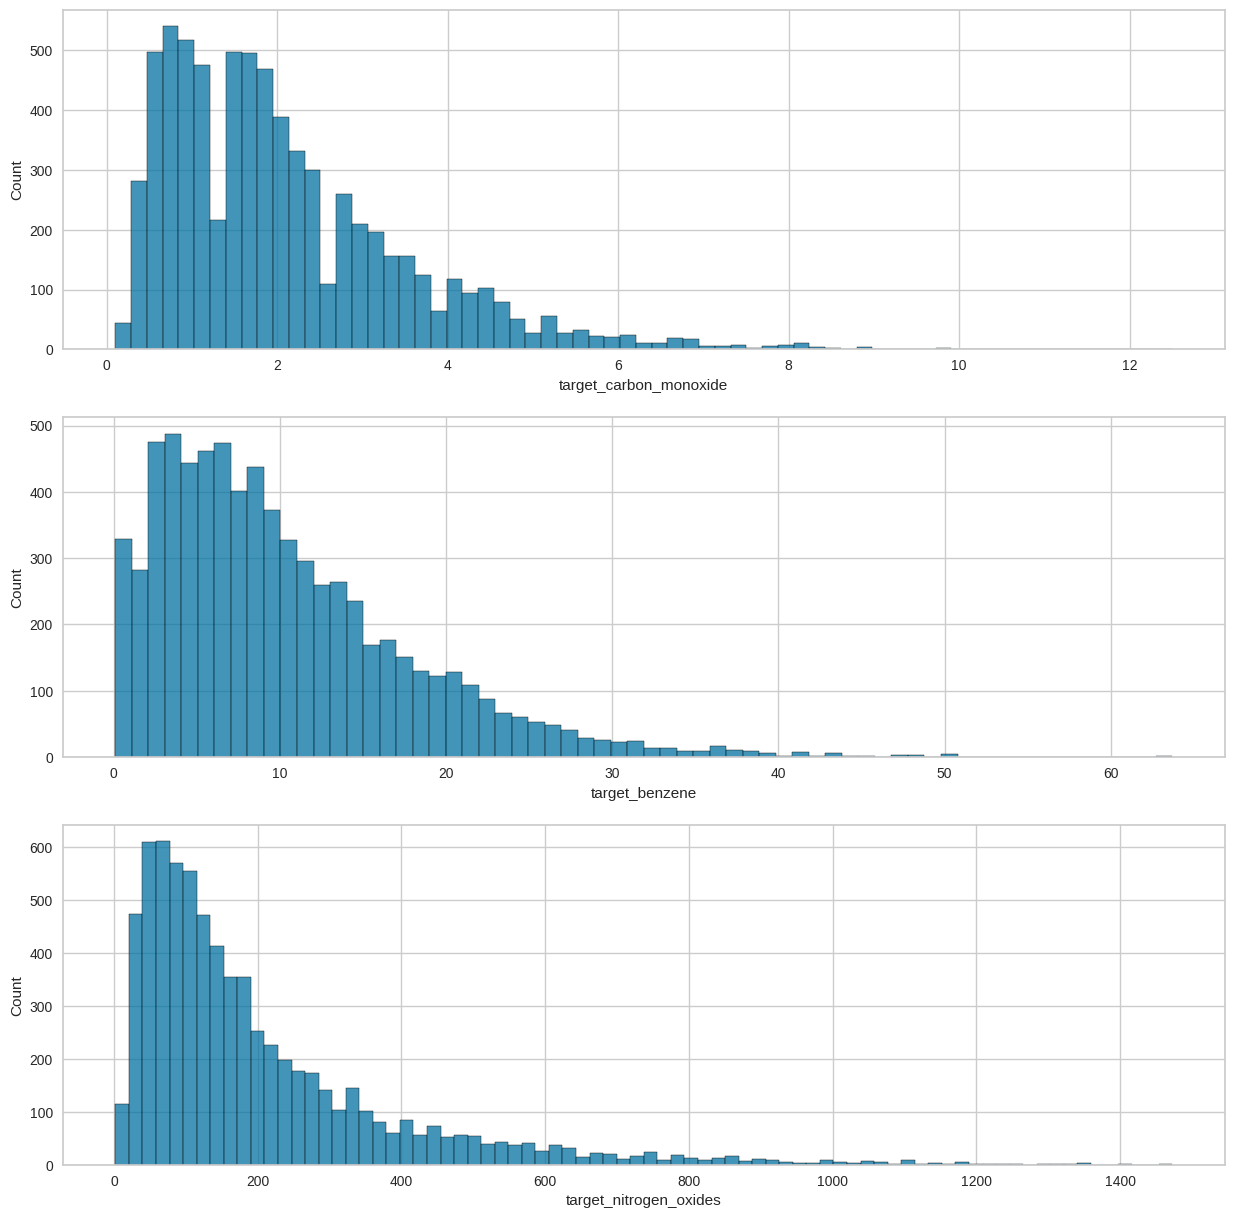

In [11]:
fig, axs = plt.subplots(3,1,figsize=(15,15))

targets =["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"]
n=0
for target in targets:
    sns.histplot(train_data[target], ax=axs[n])
    n+=1
plt.show()


#### we can see that our target values are higly skewed. to overcome this we can implement numpy log scaling

In [12]:
train_featured

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,...,day,time,hour,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,...,10,0,18,0,0,1,0,0,0,0
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,...,10,0,19,0,0,1,0,0,0,0
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,...,10,0,20,0,0,1,0,0,0,0
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,...,10,0,21,0,0,1,0,0,0,0
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,...,10,0,22,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,1.3,5.1,...,31,296,20,0,0,0,0,1,0,0
7107,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,1.4,5.8,...,31,296,21,0,0,0,0,1,0,0
7108,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,1.6,5.2,...,31,296,22,0,0,0,0,1,0,0
7109,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1.5,4.6,...,31,296,23,0,0,0,0,1,0,0


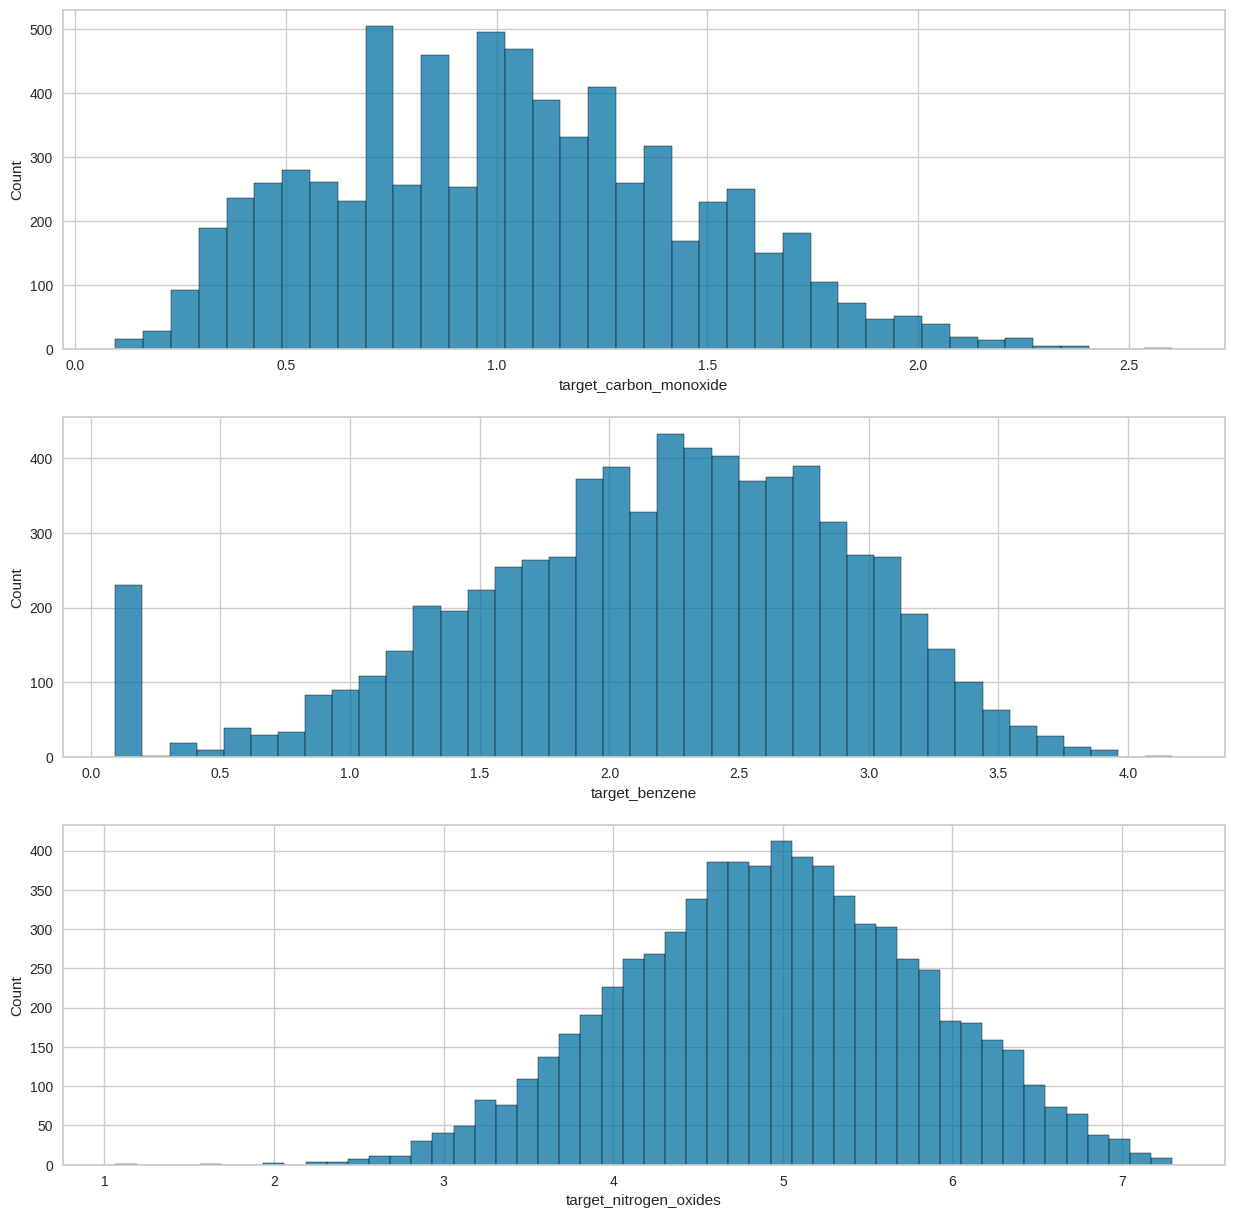

In [13]:
def scaler(col): ##defining a scaler function
    col = np.log1p(col)
    return col

##applying scaler function to target columns
for target in targets:
    train_featured[target] = scaler(train_featured[target])


##visualising scaled data
fig, axs = plt.subplots(3,1,figsize=(15,15))
n=0
for target in targets:
    sns.histplot(train_featured[target], ax=axs[n])
    n+=1
plt.show()

#### after scaling data is in proper form for predictions

In [14]:
train_co = train_featured.drop(columns = ['target_benzene', 'target_nitrogen_oxides'])
train_be = train_featured.drop(columns = ['target_carbon_monoxide', 'target_nitrogen_oxides'])
train_no = train_featured.drop(columns = ['target_carbon_monoxide', 'target_benzene'])

test_co = test_featured.drop(columns = ['target_benzene', 'target_nitrogen_oxides',"target_carbon_monoxide"])
test_be = test_featured.drop(columns = ['target_benzene', 'target_nitrogen_oxides',"target_carbon_monoxide"])
test_no = test_featured.drop(columns = ['target_benzene', 'target_nitrogen_oxides',"target_carbon_monoxide"])

In [15]:
test_featured.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2247 entries, 0 to 2246
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   deg_C                   2247 non-null   float64
 1   relative_humidity       2247 non-null   float64
 2   absolute_humidity       2247 non-null   float64
 3   sensor_1                2247 non-null   float64
 4   sensor_2                2247 non-null   float64
 5   sensor_3                2247 non-null   float64
 6   sensor_4                2247 non-null   float64
 7   sensor_5                2247 non-null   float64
 8   target_carbon_monoxide  0 non-null      float64
 9   target_benzene          0 non-null      float64
 10  target_nitrogen_oxides  0 non-null      float64
 11  year                    2247 non-null   int64  
 12  month                   2247 non-null   int64  
 13  day                     2247 non-null   int64  
 14  time                    2247 non-null   

## EXploratory Data Analysis

### Heatmap of the features

<Axes: >

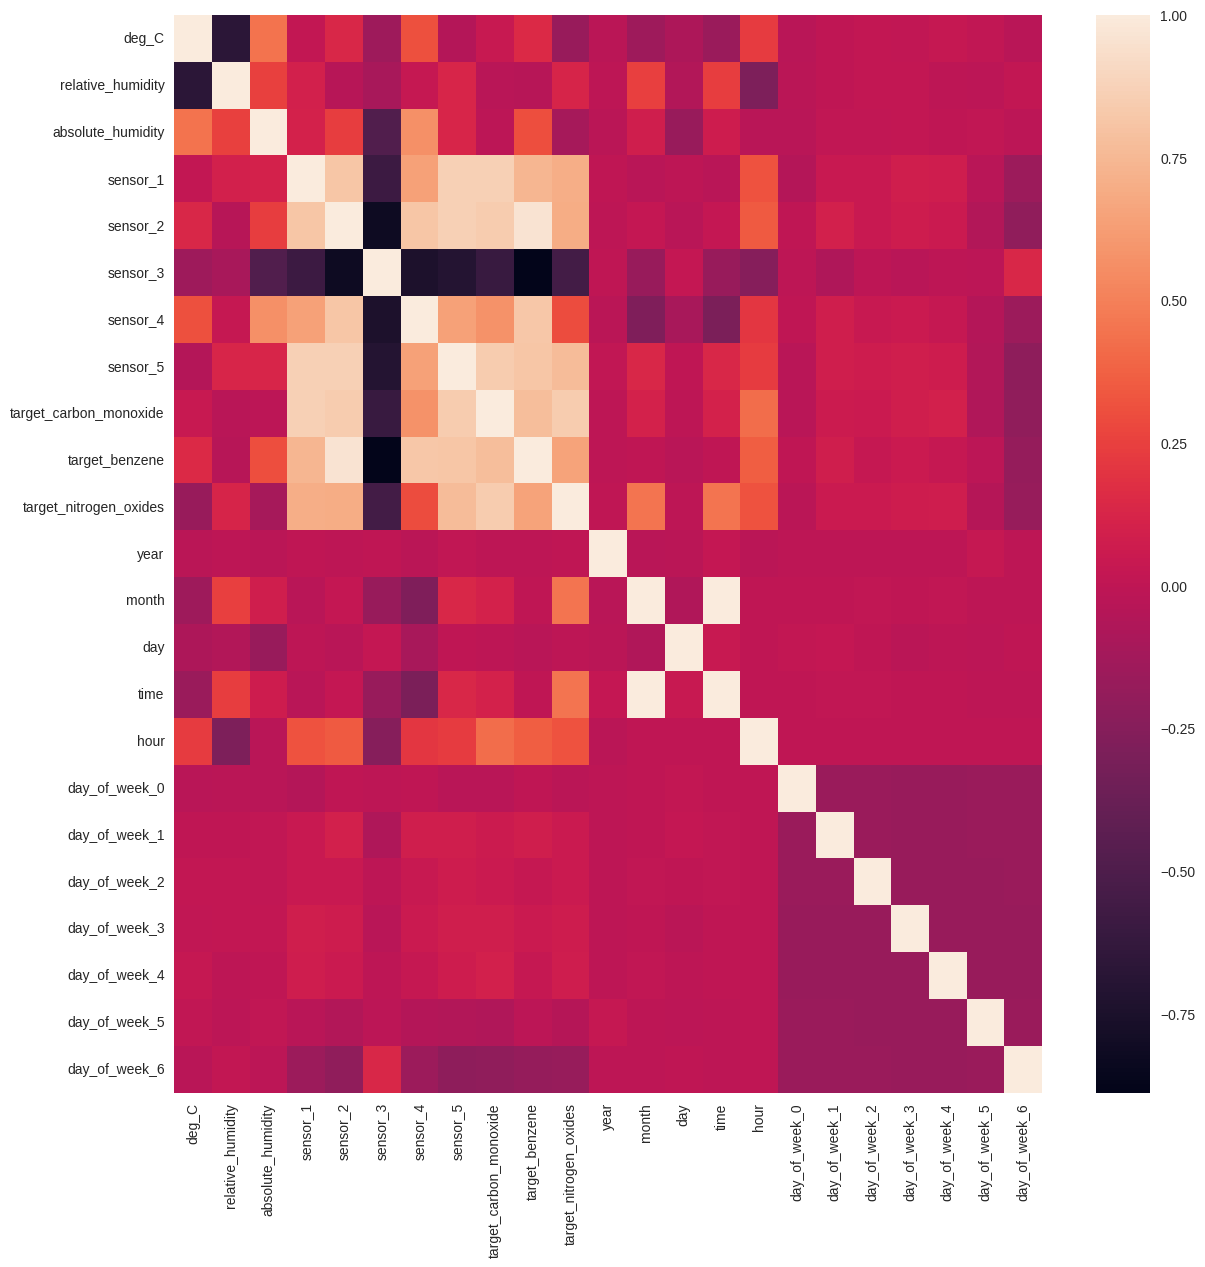

In [16]:
plt.figure(figsize=(14,14))
sns.heatmap(train_featured.corr())

#### sensor_3 is diffrent from others!! check it later

### Relations of sensors and targets

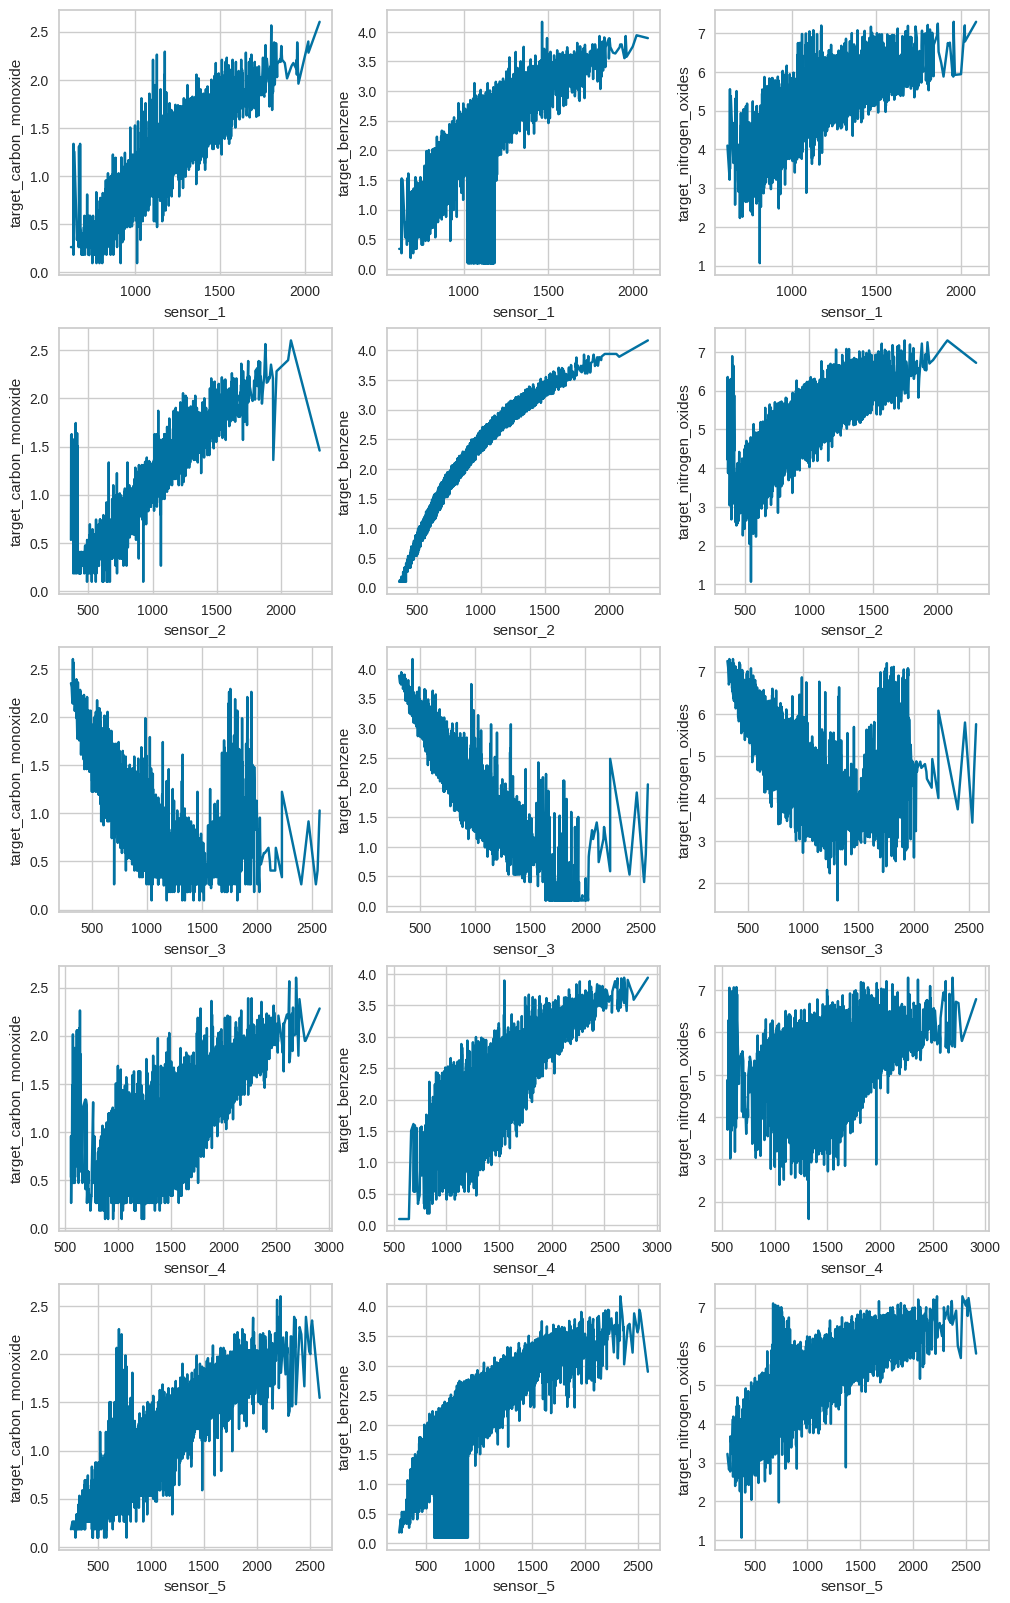

In [17]:
fig, axs = plt.subplots(5,3, figsize=(12,20))
targets =["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"]
sensors= ["sensor_1","sensor_2","sensor_3","sensor_4","sensor_5"]
k=0
for sensor in sensors:
    n=0
    for target in targets:
        sns.lineplot(train_featured.groupby(train_featured[sensor])[target].mean() ,ax=axs[k,n])
        n+=1
    k+=1
plt.show()

### Time data to targets relevence 

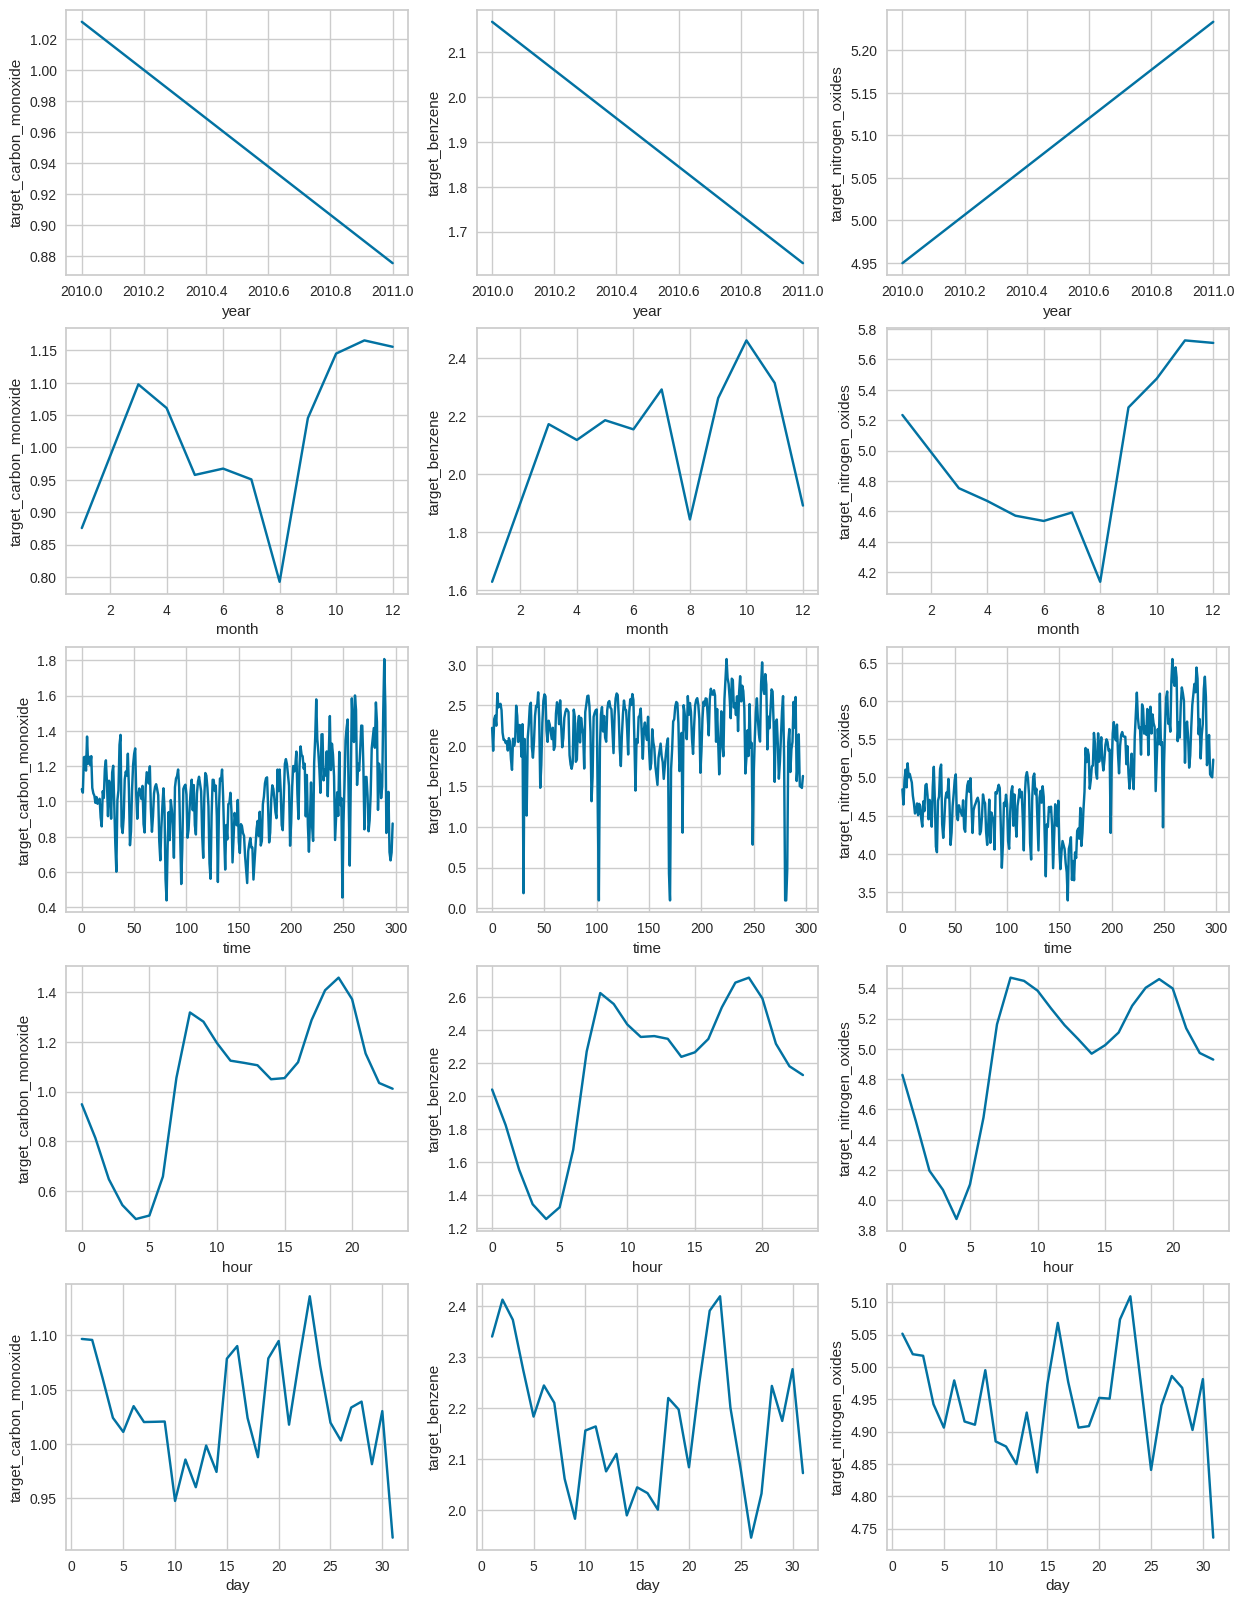

In [18]:
time_columns = ["year","month","time","hour","day"]
fig,axs = plt.subplots(5,3,figsize=(15,20))
k=0
for time in time_columns:
    n=0
    for target in targets:
        sns.lineplot(train_featured.groupby(train_featured[time])[target].mean() ,ax=axs[k,n])
        n+=1
    k+=1
plt.show()

## Building auto model pipeline

In [19]:
def pycaret_model(train, target, test, n_select=5, fold=3, opt="RMSLE"):
  print('Setup Your Data....')
  setup(data=train,
              target=target,
              numeric_imputation = 'mean')
  
  print('Comparing Models....')
  best = compare_models(sort=opt, n_select=n_select, fold = fold, exclude = ['xgboost'])

  print('Best Model Feature Importances!')
  plot_model(estimator = best[0], plot = 'feature')

  print('Blending Models....')
  blended = blend_models(estimator_list= best, fold=fold, optimize=opt)
  pred_holdout = predict_model(blended)
    
  print('Finalizing Models....')
  final_model = finalize_model(blended)
  print('Done...!!!')

  pred_esb = predict_model(final_model, test)
  re = pred_esb

  return re

Setup Your Data....


,Description,Value
0,Session id,7727
1,Target,target_carbon_monoxide
2,Target type,Regression
3,Original data shape,"(7111, 21)"
4,Transformed data shape,"(7111, 21)"
5,Transformed train set shape,"(4977, 21)"
6,Transformed test set shape,"(2134, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


Comparing Models....


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0697,0.0091,0.0956,0.9501,0.0490,0.0886,2.8433
lightgbm,Light Gradient Boosting Machine,0.0747,0.0105,0.1026,0.9424,0.0524,0.0947,0.6667
et,Extra Trees Regressor,0.0794,0.0120,0.1096,0.9343,0.0565,0.1026,0.7100
gbr,Gradient Boosting Regressor,0.0818,0.0125,0.1120,0.9314,0.0578,0.1066,0.6000
rf,Random Forest Regressor,0.0841,0.0138,0.1176,0.9242,0.0603,0.1085,1.2400
knn,K Neighbors Regressor,0.1021,0.0193,0.1390,0.8942,0.0717,0.1309,0.0733
lr,Linear Regression,0.1068,0.0225,0.1499,0.8769,0.0765,0.1424,1.2067
ridge,Ridge Regression,0.1070,0.0225,0.1501,0.8766,0.0766,0.1428,0.0400
br,Bayesian Ridge,0.1071,0.0226,0.1502,0.8765,0.0767,0.1429,0.0433
ada,AdaBoost Regressor,0.1187,0.0234,0.1529,0.8718,0.0805,0.1640,0.2933


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Best Model Feature Importances!


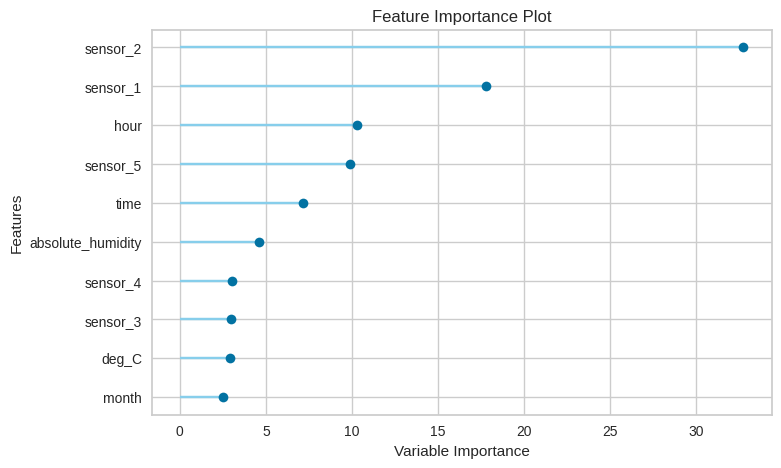

Blending Models....


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0743,0.0110,0.1049,0.9429,0.0548,0.0995
1,0.0729,0.0101,0.1004,0.9431,0.0519,0.0969
2,0.0758,0.0106,0.1030,0.9407,0.0518,0.0917
Mean,0.0743,0.0106,0.1028,0.9422,0.0528,0.0960
Std,0.0012,0.0004,0.0018,0.0011,0.0014,0.0033


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0734,0.0105,0.1025,0.9440,0.0513,0.0881


Finalizing Models....
Done...!!!


In [20]:
sub = pd.read_csv('../input/tabular-playground-series-jul-2021/sample_submission.csv')
sub_target_carbon_monoxide = np.exp(pycaret_model(train_co, 'target_carbon_monoxide', test_co, 5, 3, 'RMSLE'))-1

In [21]:
sub_target_carbon_monoxide

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,year,month,...,time,hour,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,prediction_label
0,2.979958e+03,8.636977e+17,0.548830,inf,inf,inf,inf,inf,inf,1.71875,...,9.670772e+128,0.000000e+00,0.00000,0.0,0.0,0.0,0.0,1.71875,0.0,1.578307
1,1.630219e+02,2.838082e+22,0.578382,inf,inf,inf,inf,inf,inf,1.71875,...,9.670772e+128,1.718750e+00,0.00000,0.0,0.0,0.0,0.0,1.71875,0.0,2.120885
2,3.292997e+02,2.323624e+22,0.598235,inf,inf,inf,inf,inf,inf,1.71875,...,9.670772e+128,6.390625e+00,0.00000,0.0,0.0,0.0,0.0,1.71875,0.0,1.853940
3,1.474132e+02,5.171316e+22,0.598874,inf,inf,inf,inf,inf,inf,1.71875,...,9.670772e+128,1.907812e+01,0.00000,0.0,0.0,0.0,0.0,1.71875,0.0,1.985122
4,8.901713e+01,9.374167e+24,0.592014,inf,inf,inf,inf,inf,inf,1.71875,...,9.670772e+128,5.359375e+01,0.00000,0.0,0.0,0.0,0.0,1.71875,0.0,1.407263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,1.190234e+10,2.912406e+12,1.131445,inf,inf,inf,inf,inf,inf,53.59375,...,2.370544e+169,2.203200e+04,1.71875,0.0,0.0,0.0,0.0,0.00000,0.0,2.935307
2243,4.367318e+10,5.910522e+09,1.037859,inf,inf,inf,inf,inf,inf,53.59375,...,2.370544e+169,5.987200e+04,1.71875,0.0,0.0,0.0,0.0,0.00000,0.0,2.352326
2244,3.566428e+11,1.784823e+08,0.897619,inf,inf,inf,inf,inf,inf,53.59375,...,2.370544e+169,inf,1.71875,0.0,0.0,0.0,0.0,0.00000,0.0,2.465184
2245,4.344798e+12,3.277468e+05,0.671798,inf,inf,inf,inf,inf,inf,53.59375,...,2.370544e+169,inf,1.71875,0.0,0.0,0.0,0.0,0.00000,0.0,2.145607


Setup Your Data....


,Description,Value
0,Session id,195
1,Target,target_benzene
2,Target type,Regression
3,Original data shape,"(7111, 21)"
4,Transformed data shape,"(7111, 21)"
5,Transformed train set shape,"(4977, 21)"
6,Transformed test set shape,"(2134, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


Comparing Models....


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0683,0.0072,0.0851,0.9876,0.0297,0.0421,2.5100
lightgbm,Light Gradient Boosting Machine,0.0716,0.0079,0.0888,0.9865,0.0308,0.0407,0.6067
et,Extra Trees Regressor,0.0743,0.0085,0.0919,0.9855,0.0314,0.0388,1.8567
rf,Random Forest Regressor,0.0748,0.0086,0.0929,0.9852,0.0318,0.0395,3.1800
gbr,Gradient Boosting Regressor,0.0759,0.0086,0.0926,0.9853,0.0319,0.0442,1.3500
ada,AdaBoost Regressor,0.0907,0.0114,0.1070,0.9804,0.0416,0.0928,0.7467
knn,K Neighbors Regressor,0.0906,0.0137,0.1171,0.9765,0.0417,0.0489,0.1133
dt,Decision Tree Regressor,0.0995,0.0164,0.1280,0.9719,0.0436,0.0520,0.1067
br,Bayesian Ridge,0.1111,0.0226,0.1503,0.9613,0.0595,0.1146,0.3300
ridge,Ridge Regression,0.1115,0.0228,0.1510,0.9609,0.0598,0.1140,0.2400


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Best Model Feature Importances!


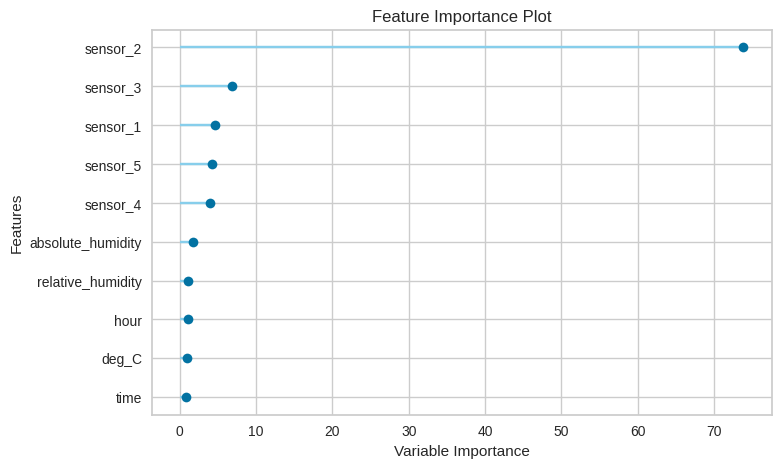

Blending Models....


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0704,0.0076,0.0874,0.9870,0.0294,0.0377
1,0.0717,0.0077,0.0876,0.9869,0.0302,0.0409
2,0.0704,0.0076,0.0870,0.9870,0.0302,0.0391
Mean,0.0708,0.0076,0.0873,0.9869,0.0300,0.0392
Std,0.0006,0.0000,0.0002,0.0000,0.0004,0.0013


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0712,0.0077,0.0876,0.9865,0.0302,0.0387


Finalizing Models....
Done...!!!


In [22]:
sub_target_benzene = np.exp(pycaret_model(train_be, 'target_benzene', test_be, 5, 3, 'RMSLE'))-1

Setup Your Data....


,Description,Value
0,Session id,4310
1,Target,target_nitrogen_oxides
2,Target type,Regression
3,Original data shape,"(7111, 21)"
4,Transformed data shape,"(7111, 21)"
5,Transformed train set shape,"(4977, 21)"
6,Transformed test set shape,"(2134, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


Comparing Models....


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1448,0.0380,0.1948,0.9513,0.0362,0.0314,2.4567
lightgbm,Light Gradient Boosting Machine,0.1525,0.0420,0.2050,0.9461,0.0380,0.0330,0.6233
et,Extra Trees Regressor,0.1548,0.0434,0.2083,0.9443,0.0388,0.0336,1.8900
rf,Random Forest Regressor,0.1632,0.0479,0.2188,0.9386,0.0406,0.0353,3.1933
gbr,Gradient Boosting Regressor,0.1675,0.0497,0.2230,0.9362,0.0410,0.0361,1.3400
knn,K Neighbors Regressor,0.2310,0.0941,0.3067,0.8795,0.0559,0.0497,0.1033
ada,AdaBoost Regressor,0.2464,0.0994,0.3151,0.8730,0.0564,0.0524,0.6533
dt,Decision Tree Regressor,0.2334,0.0976,0.3121,0.8754,0.0575,0.0503,0.1067
ridge,Ridge Regression,0.2641,0.1771,0.4109,0.7729,0.0643,0.0566,0.2467
en,Elastic Net,0.2881,0.1467,0.3830,0.8121,0.0685,0.0623,0.2767


Processing:   0%|          | 0/84 [00:00<?, ?it/s]

Best Model Feature Importances!


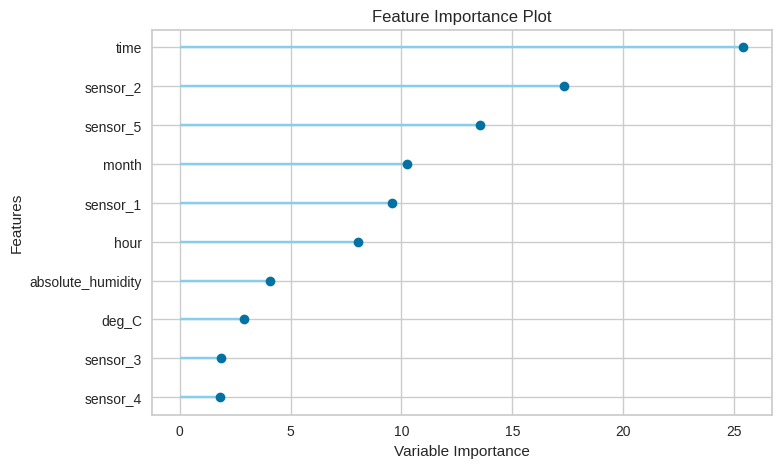

Blending Models....


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1478,0.0398,0.1995,0.9514,0.0377,0.0322
1,0.1513,0.0421,0.2052,0.9436,0.0381,0.0326
2,0.1438,0.0367,0.1915,0.9529,0.0352,0.0311
Mean,0.1477,0.0395,0.1987,0.9493,0.0370,0.0320
Std,0.0031,0.0022,0.0056,0.0041,0.0013,0.0006


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1481,0.0432,0.2079,0.9437,0.0396,0.0325


Finalizing Models....
Done...!!!


In [23]:
sub_target_nitrogen_oxides = np.exp(pycaret_model(train_no, 'target_nitrogen_oxides', test_no, 4, 3, 'RMSLE')) - 1

In [24]:
sub_target_carbon_monoxide.rename(columns={"prediction_label":"target_carbon_monoxide"},inplace=True)
sub_target_benzene.rename(columns={"prediction_label":"target_benzene"},inplace=True)
sub_target_nitrogen_oxides.rename(columns={"prediction_label":"target_nitrogen_oxides"},inplace=True)

In [27]:
 sub = pd.concat([test_data["date_time"],sub_target_carbon_monoxide["target_carbon_monoxide"],sub_target_benzene["target_benzene"],sub_target_nitrogen_oxides["target_nitrogen_oxides"]],axis=1)

In [28]:
sub.set_index("date_time",inplace=True)

In [29]:
sub.to_csv('sub.csv', index=False)

In [30]:
sub

,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
date_time,,,
2011-01-01 00:00:00,1.578307,4.512943,183.695441
2011-01-01 01:00:00,2.120885,7.301974,209.091421
2011-01-01 02:00:00,1.853940,7.296962,199.820397
2011-01-01 03:00:00,1.985122,8.121193,216.448157
2011-01-01 04:00:00,1.407263,6.343662,160.568333
...,...,...,...
2011-04-04 10:00:00,2.935307,12.326032,322.855910
2011-04-04 11:00:00,2.352326,10.290056,265.622088
2011-04-04 12:00:00,2.465184,12.390312,269.884291
